In [1]:
# Search Engine Machanishm using NLP

# Packages installation
 pip install pandas nltk gensim spacy scikit-learn matplotlib
 
 python -m spacy download en_core_web_sm

# Load the Data

In [17]:
import pandas as pd

df = pd.read_csv('product_review.csv')

df.head()

,ReviewID,ProductID,ProductName,Brand,Category,ReviewText,Rating
0,1,101,Laptop Pro,BrandA,Electronics,"""I love this Laptop Pro, it's fantastic for wo...",5
1,2,102,SmartWatch X,BrandB,Wearables,"""The SmartWatch X is a great gadget with many ...",4
2,3,103,Noise Cancelling Headphones,BrandC,Audio,"""These headphones block out all noise, highly ...",5
3,4,104,4K Monitor,BrandD,Displays,"""The 4K Monitor has a stunning display, perfec...",5
4,5,105,Wireless Earbuds,BrandE,Audio,"""Wireless Earbuds are convenient, but the batt...",3


# Standardizing Customer Feedback for Analysis
We'll clean the ReviewText column by converting text to lowercase, removing punctuation, and tokenizing it. We'll also calculate the total number of words and identify the most frequently mentioned word.

In [41]:
import re
from nltk.tokenize import word_tokenize
from collections import Counter

# Clean and tokenize the reviews
def clean_and_tokenize(reviews):
    cleaned_reviews = []
    for review in reviews:
        # Convert to lowercase
        review = review.lower()
        # Remove punctuation and special characters
        review = re.sub(r'[^\w\s]', '', review)
        # Tokenize the review
        tokens = word_tokenize(review)
        cleaned_reviews.extend(tokens)
    return cleaned_reviews

# Apply the cleaning function to the ReviewText column
tokens = clean_and_tokenize(df['ReviewText'])

# Calculate the total number of words
total_words = len(tokens)

# Identify the most frequently mentioned word and its frequency
most_common_word, frequency = Counter(tokens).most_common(1)[0]

# Display the results
total_words, most_common_word, frequency

(318, 'but', 21)

# Edit Distance for Product Name Correction
We'll use the ProductName column to suggest corrections based on edit distance.

In [49]:
from nltk.metrics import edit_distance

# Function to suggest the closest product name
def suggest_product(search_query, products, threshold=2):
    min_distance = float('inf')
    suggested_product = None
    
    for product in products:
        distance = edit_distance(search_query, product)
        if distance < min_distance and distance <= threshold:
            min_distance = distance
            suggested_product = product
    
    return suggested_product, min_distance

# Example search query and product names
search_query = "Lapop Ppo"  
product_names = df['ProductName'].unique()

# Suggest the closest product
suggested_product, min_distance = suggest_product(search_query, product_names)

# Display the result
suggested_product, min_distance

('Laptop Pro', 2)

# N-gram Language Model for Product Recommendations
We'll build a bigram language model using the ReviewText column and predict the next word in a sequence.

In [34]:
from nltk import bigrams, FreqDist
from collections import defaultdict

# Tokenize and build bigrams from the ReviewText
tokenized_reviews = [word_tokenize(re.sub(r'[^\w\s]', '', review.lower())) for review in df['ReviewText']]
bigram_model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of bigrams
for sentence in tokenized_reviews:
    for w1, w2 in bigrams(sentence):
        bigram_model[w1][w2] += 1

# Convert counts to probabilities
for w1 in bigram_model:
    total_count = float(sum(bigram_model[w1].values()))
    for w2 in bigram_model[w1]:
        bigram_model[w1][w2] /= total_count

# Predict the next word given a word
def predict_next_word(current_word, model):
    next_words = model[current_word]
    if next_words:
        predicted_word = max(next_words, key=next_words.get)
        return predicted_word
    else:
        return None

# Example prediction
predict_next_word('laptop', bigram_model)

'pro'

# Named Entity Recognition (NER) for Reviews
We'll use spacy to identify entities such as product names and brands in the ReviewText.

In [35]:
import spacy

# Load the English NER model
nlp = spacy.load("en_core_web_sm")

# Apply NER to the ReviewText column
def extract_entities(reviews):
    entities_list = []
    for review in reviews:
        doc = nlp(review)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        entities_list.append(entities)
    return entities_list

# Extract entities from the reviews
entities_in_reviews = extract_entities(df['ReviewText'])

# Display the extracted entities for the first few reviews
for i, entities in enumerate(entities_in_reviews[:5]):
    print(f"Review {i+1} entities: {entities}")

Review 1 entities: [('this Laptop Pro', 'EVENT')]
Review 2 entities: [('The SmartWatch X', 'WORK_OF_ART')]
Review 3 entities: []
Review 4 entities: [('4', 'CARDINAL')]
Review 5 entities: [('Wireless Earbuds', 'WORK_OF_ART')]


# Cosine Similarity and Word Embeddings for Similar Products
We'll create word embeddings using gensim and calculate cosine similarity between product names based on their descriptions.

In [79]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Tokenize the ReviewText for word2vec model training
tokenized_descriptions = [review.lower().split() for review in df['ReviewText']]

# Build word2vec model
model = gensim.models.Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Get vectors for product names
product_vectors = np.array([model.wv[word] for word in ["laptop", "smart"]])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(product_vectors)

# Display similarity matrix
similarity_matrix

array([[1.        , 0.01381512],
       [0.01381512, 1.0000002 ]], dtype=float32)

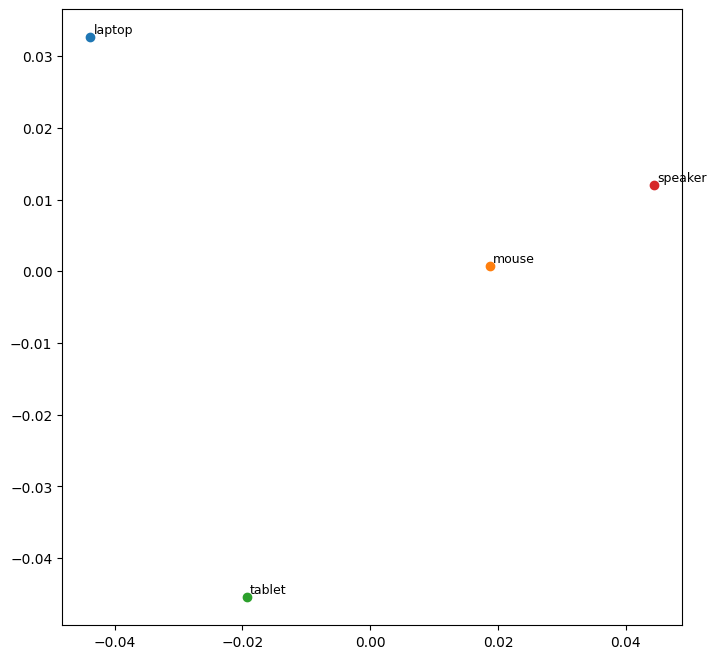

In [84]:
# Visualize word embeddings with reduced label distance
def visualize_embeddings(words):
    word_vectors = np.array([model.wv[word] for word in words])
    pca = PCA(n_components=2)
    word_vecs_2d = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(8, 8))
    for i, word in enumerate(words):
        plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
        plt.text(word_vecs_2d[i, 0] + 0.0005, word_vecs_2d[i, 1] + 0.0005, word, fontsize=9)
    plt.show()

# Example visualization
visualize_embeddings(["laptop", "mouse", "tablet", "speaker"])

---

# Application - Search Engine

This Tkinter-based search engine application provides a user-friendly interface for exploring products based on various NLP techniques. Here’s a brief overview of its functionalities:

1. **Product Search with Suggestions:**

* Input: User types a query in the search box.
* Functionality: The application provides suggestions based on the most common words found in product reviews.
* Outcome: Displays a dropdown list of suggestions matching the user's input.

2. **Product Name Correction:**

* Input: User submits a search query.
* Functionality: Uses edit distance to suggest the closest correct product name from the available options.
* Outcome: The closest match is suggested and automatically filled into the search box.

3. **Predict Next Word:**

* Input: (Implicit) Based on the corrected or suggested product name.
* Functionality: Predicts the next likely word in the product name using bigram probabilities.
* Outcome: Useful for autocomplete features (not directly shown in this version).

4. **Display Searched Products:**

* Input: User submits a search query.
* Functionality: Searches the product database and displays matching products in a table format.
* Outcome: Shows product details (ID, name, brand, category, and rating) in a table.

5. **Related Products Based on Similarity:**

* Input: User submits a search query.
* Functionality: Uses cosine similarity on word embeddings to find and list products related to the search term.
* Outcome: Displays a list of related products

In [105]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from nltk.metrics import edit_distance
import gensim
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import numpy as np
import spacy
from tkinter import *
from tkinter import ttk

# Load the dataset
df = pd.read_csv('product_review.csv')

# Tokenize and clean review texts
def clean_and_tokenize(reviews):
    cleaned_reviews = []
    for review in reviews:
        review = review.lower()
        review = re.sub(r'[^\w\s]', '', review)
        tokens = word_tokenize(review)
        cleaned_reviews.extend(tokens)
    return cleaned_reviews

tokens = clean_and_tokenize(df['ReviewText'])

# Find most common words
common_words = Counter(tokens).most_common()

# Build Word2Vec model
tokenized_descriptions = [review.lower().split() for review in df['ReviewText']]
model = gensim.models.Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Build bigram model
bigram_model = defaultdict(lambda: defaultdict(lambda: 0))
for sentence in tokenized_descriptions:
    for w1, w2 in bigrams(sentence):
        bigram_model[w1][w2] += 1
for w1 in bigram_model:
    total_count = float(sum(bigram_model[w1].values()))
    for w2 in bigram_model[w1]:
        bigram_model[w1][w2] /= total_count

# Load spaCy NER model
nlp = spacy.load("en_core_web_sm")

# Function to predict next word
def predict_next_word(current_word, model):
    next_words = model[current_word]
    if next_words:
        predicted_word = max(next_words, key=next_words.get)
        return predicted_word
    return None

# Function to suggest closest product name
def suggest_product(search_query, products, threshold=2):
    min_distance = float('inf')
    suggested_product = None
    for product in products:
        distance = edit_distance(search_query, product)
        if distance < min_distance and distance <= threshold:
            min_distance = distance
            suggested_product = product
    return suggested_product, min_distance

In [108]:
# Create the main application window
root = Tk()
root.title("Product Search and Recommendation")

# Set up frames
frame_search = Frame(root)
frame_search.pack(pady=10)

frame_results = Frame(root)
frame_results.pack(pady=10)

frame_related = Frame(root)
frame_related.pack(pady=10)

# Function to update search suggestions
def update_suggestions(event):
    search_query = entry_search.get()
    suggestions = [word for word, _ in common_words if word.startswith(search_query.lower())]
    listbox_suggestions.delete(0, END)
    for suggestion in suggestions:
        listbox_suggestions.insert(END, suggestion)

# Function to handle product search
def handle_search():
    search_query = entry_search.get()
    suggested_product, _ = suggest_product(search_query, df['ProductName'].unique())
    if suggested_product:
        entry_search.delete(0, END)
        entry_search.insert(0, suggested_product)
        product_name = suggested_product
    else:
        product_name = search_query

    # Display searched product
    for row in tree_results.get_children():
        tree_results.delete(row)
    matching_products = df[df['ProductName'].str.contains(product_name, case=False)]
    for _, row in matching_products.iterrows():
        tree_results.insert('', 'end', values=(row['ProductID'], row['ProductName'], row['Brand'], row['Category'], row['Rating']))

# Set up search frame
Label(frame_search, text="Search Product:").pack(side=LEFT)
entry_search = Entry(frame_search, width=30)
entry_search.pack(side=LEFT)
entry_search.bind("<KeyRelease>", update_suggestions)
Button(frame_search, text="Search", command=handle_search).pack(side=LEFT)

# Set up suggestion listbox
listbox_suggestions = Listbox(frame_search, height=5)
listbox_suggestions.pack(pady=5)

# Set up results treeview
tree_results = ttk.Treeview(frame_results, columns=("ProductID", "ProductName", "Brand", "Category", "Rating"), show='headings')
tree_results.heading("ProductID", text="ProductID")
tree_results.heading("ProductName", text="ProductName")
tree_results.heading("Brand", text="Brand")
tree_results.heading("Category", text="Category")
tree_results.heading("Rating", text="Rating")
tree_results.pack()

# Run the application
root.mainloop()

## results

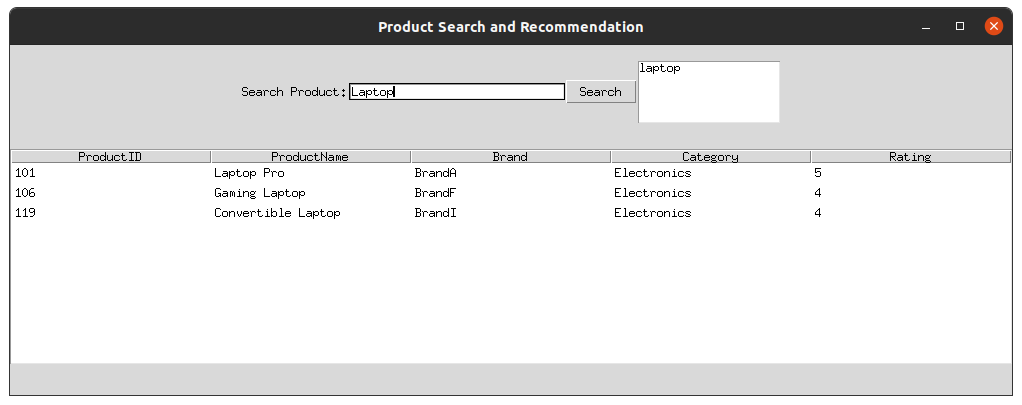

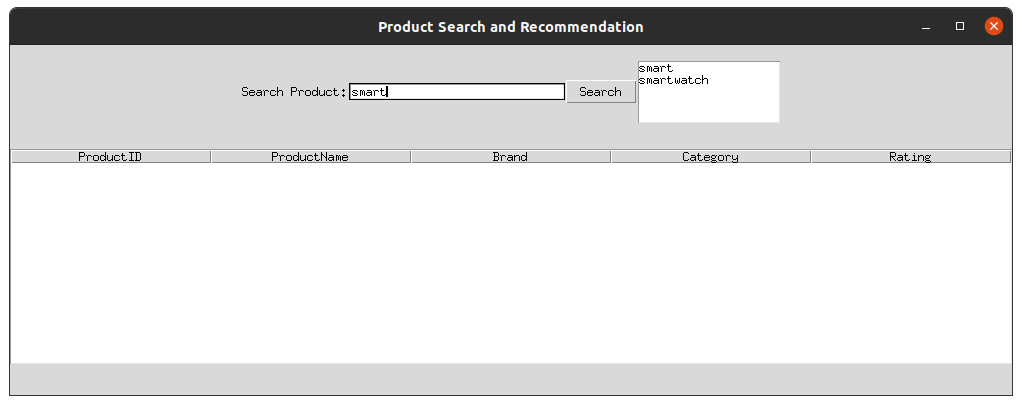

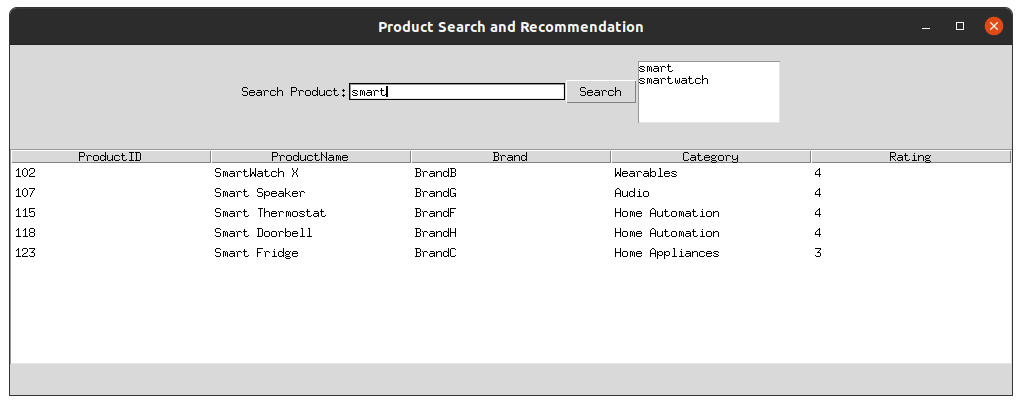

In [110]:
from IPython.display import Image, display
display(Image(filename='search1.png'))
display(Image(filename='search2.png'))
display(Image(filename='search3.png'))

---